In [70]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy,os,glob
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
% matplotlib inline

In [71]:
mesh=nc.Dataset('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/mesh_files/mesh_mask_rm1Canada.nc')

In [72]:
mbathy=mesh.variables['mbathy'][0,700,210]
gdept=mesh.variables['gdept'][0,:mbathy,700,210]
gdepw=mesh.variables['gdepw'][0,:mbathy,700,210]
e3t=mesh.variables['e3t'][0,:mbathy,700,210]
e3w=mesh.variables['e3w'][0,:mbathy+1,700,210]

In [73]:
ice=nc.Dataset('/ocean/xiaoxiny/research/data/forcing/Ice/noaa_icemod_y1958m09.nc')
ice=ice.variables['ileadfra'][0,700,210]
print ice

xd=nc.Dataset('/ocean/xiaoxiny/research/data/init_files/newzero_ANHA_Th_diss.nc')
xd=xd.variables['Th_diss'][0,:mbathy,700,210]

xp=nc.Dataset('/ocean/xiaoxiny/research/data/init_files/newzero_ANHA_Th_part.nc')
xp=xp.variables['Th_part'][0,:mbathy,700,210]

0.797721


In [74]:
import pylab

I = np.zeros(gdept.shape) # Ice signal
S = np.zeros(gdept.shape)
k_ad = np.zeros(gdept.shape)

Q = 0.0267     #dpm/m^3
k_de = 0.8     #desorption constants

In [75]:
# time info
dt = 1./365/24/3600*1080
t = 0.0
tmax = 2  #run the model for 2 years

# initialize the data 
xd_=np.copy(xd)
xp_=np.copy(xp)


anew=np.zeros(xd.shape)
bnew=np.zeros(xd.shape)
cnew=np.zeros(xd.shape)

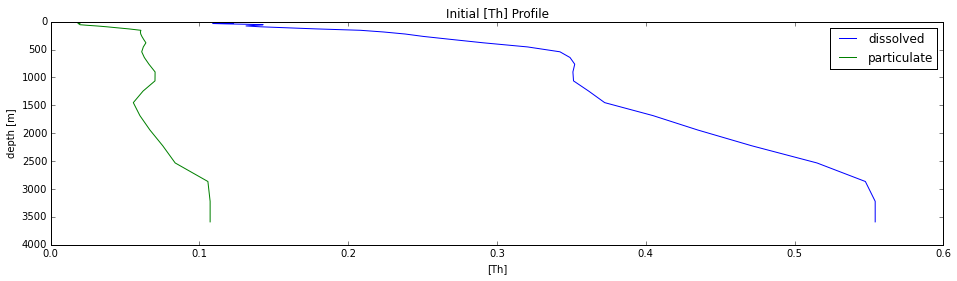

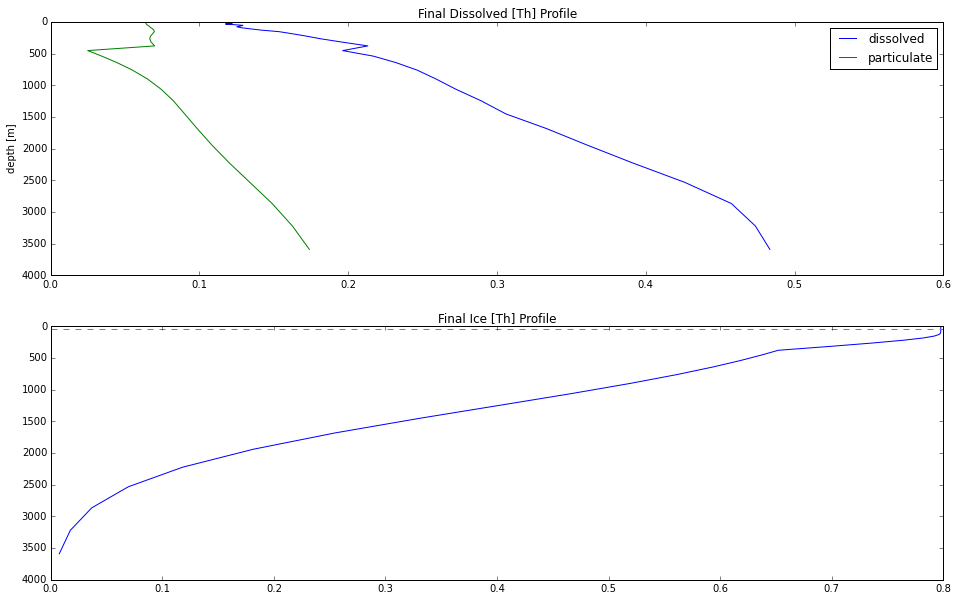

In [76]:
while (t < tmax):               # loop through all dt on [0, tmax]
    I[:16]=ice                   # ice/sinking rate/adsorption constants
    S[:30] = -689.3*I[:30]+1323*0.5   
    S[30:] = -689.3*I[30:]+1323       
    k_ad[:] = 0.23*I[:]+0.37
    
    i=0                         # the surface BC.
    anew[i] = xd_[i+1]           
    bnew[i] = xp_[i+1] 
    cnew[i] = I[i+1]        
    
    i += 1
    while (i <= mbathy-1):     # loop through all depths
        
        # forward difference
        anew[i] = xd_[i] + (Q - k_ad[i]*xd_[i] + k_de*xp_[i]) * dt

        bnew[i] = xp_[i] + ((S[i-1]*xp_[i-1]-S[i]*xp_[i])/e3w[i+1] 
                  + k_ad[i]*xd_[i] - k_de*xp_[i]) * dt
        
        cnew[i] = I[i] + (I[i-1]-I[i])*S[i]/e3w[i+1] * dt
        
        i += 1

    # store the updated solution
    xd_[:] = anew[:]
    xp_[:] = bnew[:]
    I[:]   = cnew[:]

    t += dt


# initial dissolved and particulate
pylab.figure(1, figsize = (16, 4))  
pylab.plot(xd, gdept)
pylab.plot(xp, gdept)

# final dissolved and particulate
pylab.figure(2, figsize = (16, 10))
pylab.subplot(211)
pylab.plot(xd_, gdept)
pylab.plot(xp_, gdept)
pylab.subplot(212)
pylab.plot(I, gdept)
pylab.axhline(y=gdept[16],color='grey',ls='--')
    

# label and scale plots
pylab.figure(2, figsize = (16, 8))
pylab.subplot(211)
pylab.ylabel('depth [m]')
pylab.title('Final Dissolved [Th] Profile')
pylab.legend(['dissolved', 'particulate'])
pylab.gca().invert_yaxis()
pylab.xlim([0,0.6])
pylab.subplot(212)
pylab.title('Final Ice [Th] Profile')
pylab.gca().invert_yaxis()


pylab.figure(1, figsize = (16, 4))
pylab.gca().invert_yaxis()
pylab.title('Initial [Th] Profile')
pylab.legend(['dissolved', 'particulate'])
pylab.ylabel('depth [m]')
pylab.xlabel('[Th]')

ps. The initial ice condition is zero for all depths.

In [77]:
I

array([ 0.79772079,  0.79772079,  0.79772079,  0.79772079,  0.79772079,
        0.79772079,  0.79772079,  0.79772079,  0.79772079,  0.79772079,
        0.79772079,  0.79772079,  0.79772079,  0.79772079,  0.79772079,
        0.79772079,  0.79772079,  0.79772079,  0.79772079,  0.79772075,
        0.79771939,  0.79769565,  0.79747228,  0.79624865,  0.79202966,
        0.78200243,  0.76384463,  0.73638031,  0.69920215,  0.65214324,
        0.63745585,  0.61842926,  0.59364814,  0.56135558,  0.51965439,
        0.46706978,  0.40348185,  0.33109117,  0.25480594,  0.18151799,
        0.11821867,  0.069665  ,  0.03688984,  0.01771486,  0.00785644])

In [78]:
xp_

array([ 0.06383178,  0.06383222,  0.0638327 ,  0.0638331 ,  0.06383488,
        0.06383681,  0.06384349,  0.06385598,  0.06387575,  0.06390487,
        0.06394576,  0.06401058,  0.06409766,  0.06422574,  0.06433499,
        0.06437991,  0.06451581,  0.0648631 ,  0.06548263,  0.06611627,
        0.0666502 ,  0.06742118,  0.06852296,  0.06945536,  0.0697794 ,
        0.06870211,  0.06730882,  0.06666013,  0.0675534 ,  0.06999569,
        0.02500842,  0.03442081,  0.04465695,  0.05516348,  0.06520232,
        0.07428974,  0.0825348 ,  0.09013519,  0.09858339,  0.10838199,
        0.12013857,  0.13400349,  0.14892492,  0.16257864,  0.17392983], dtype=float32)

In [79]:
S

array([  111.63105952,   111.63105952,   111.63105952,   111.63105952,
         111.63105952,   111.63105952,   111.63105952,   111.63105952,
         111.63105952,   111.63105952,   111.63105952,   111.63105952,
         111.63105952,   111.63105952,   111.63105952,   111.63105952,
         111.63105952,   111.63105952,   111.63105983,   111.63108609,
         111.6320228 ,   111.64838969,   111.80238755,   112.64593204,
         115.55433412,   122.466525  ,   134.98322301,   153.91496767,
         179.54249884,   211.98085929,   883.60519775,   896.72064392,
         913.80280655,   936.06273811,   964.80816251,  1001.05559673,
        1044.88754024,  1094.78692308,  1147.37028586,  1197.88696644,
        1241.51788891,  1274.98431172,  1297.57465885,  1310.79075694,
        1317.58538732])